# Network studies for Popular Logical Fallacies for CreateDebate forum

There are 13 different logical fallacies in the LOGIC dataset ([paper](https://arxiv.org/abs/2202.13758), [github](https://github.com/causalNLP/logical-fallacy)). We fine-tuned BERT (base, uncased) model on this datatset, and used it to classify comments in CreateDebate into one of the fallacies. The distribution of various fallacies is shown in the plot below.

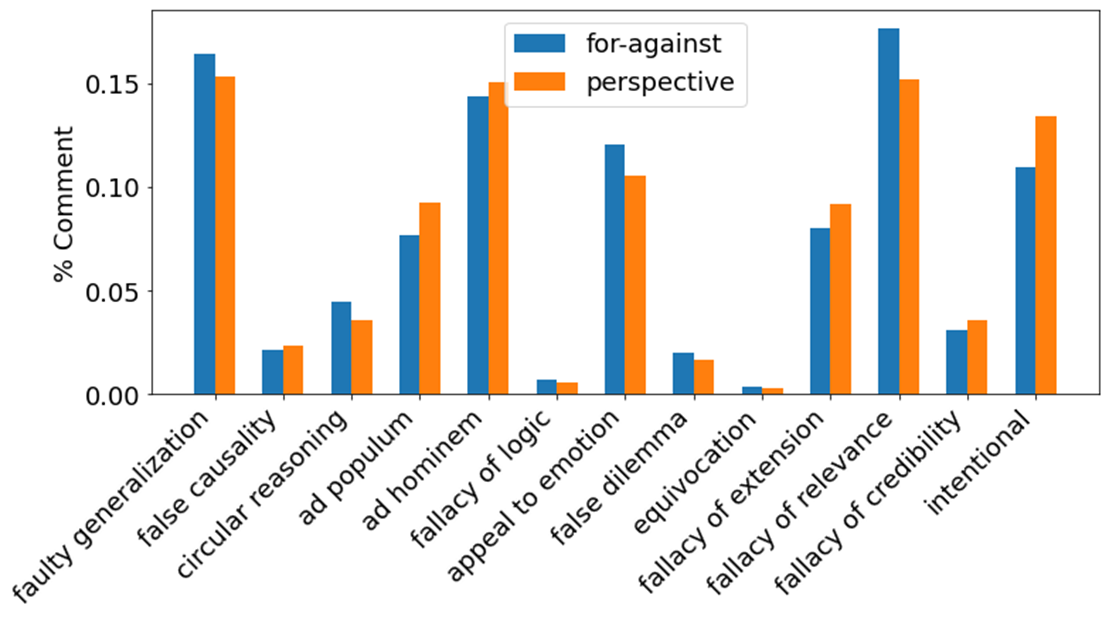

For this notebook, we will select top logical fallacies on the basis of their percentage in total comments, instead of complex clustering strategies.

The top 5 logical fallacies are:
* fallacy of relevance
* faulty generalization
* ad hominem
* intentional
* appeal to emotion

# Notebook Utils

In [1]:
# Mount Google drive to Colab
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
# Clone `CreateDebateScraper` library from github for handling
# CreateDebate dataset
!git clone https://github.com/utkarsh512/CreateDebateScraper.git
%cd CreateDebateScraper/src/nested/

Cloning into 'CreateDebateScraper'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 176 (delta 5), reused 4 (delta 4), pack-reused 170
Receiving objects: 100% (176/176), 207.95 KiB | 13.86 MiB/s, done.
Resolving deltas: 100% (61/61), done.
/content/CreateDebateScraper/src/nested


In [3]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib
from   matplotlib import pyplot as plt
import seaborn as sns

from thread import (Comment,
                    Thread)

from collections import deque
from copy import deepcopy
import pickle
import json
from tqdm import tqdm
from pprint import pprint
from functools import lru_cache

import networkx as nx
import spacy
import nltk 

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [83]:
matplotlib.rcParams['figure.figsize'] = (18, 5)

In [4]:
# Setup for plotting
sns.set(style='darkgrid')
matplotlib.rcParams['figure.dpi'] = 120
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['figure.figsize'] = (10, 5)

# Setup for nltk
nltk.download('punkt') # For tokenizers
nltk.download('stopwords')
nltk.download('wordnet') # For lemmatizers
nltk.download('omw-1.4')
from nltk.stem import WordNetLemmatizer

# Setup for spacy
!python -m spacy download en_core_web_sm
scapy_nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-02-07 10:44:11.379309: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Dataset Utils

In [5]:
comments = dict()

# Topical forums on CreateDebate. We have scraped comments for all of the
# following forurm.
categories = ['business', 'comedy', 'entertainment', 'health', 'law', 'nsfw',
              'politics2', 'religion', 'science', 'shopping', 'sports',
              'technology', 'travel', 'world']

# However, we will be analyzing comments from selected forum only!
# These forum have at least 10k comments each.
categories_selected = ['politics2', 'religion', 'world', 
                       'science', 'law', 'technology']

for x in categories_selected:
    comments[x] = list()

In [6]:
# Loading comments from select forums

for cat in tqdm(categories_selected):
    fp = open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/threads.log', 'rb')

    # Get all the `Thread` objects pickled while scraping.
    threads = list()
    try:
        while True:
            e = pickle.load(fp)
            threads.append(e)
    except EOFError:
        fp.close()

    # While classifying CreateDebate comments, we used comments as per author mode.
    # Hence, using the same mode to attach classification score with the comments.
    # 
    # score < 0.5 -> ad hominem comment
    #       > 0.5 -> non ad hominem comment
    authors = dict()
    for thread in threads:
        for k, v in thread.comments.items():
            try:
                authors[v.author].append((v, k))
            except:
                authors[v.author] = list()
                authors[v.author].append((v, k))

    ctr = 0
    # Load the classification score of the comments.
    with open('/content/gdrive/MyDrive/DL/CreateDebate/' + cat + '/comments_with_score.log', 'rb') as fp:
        cws = pickle.load(fp)
    # Attach classification score with the comments.
    for author in authors.keys():
        for i in range(len(authors[author])):
            comment, cid = authors[author][i]
            foo = deepcopy(comment.__dict__)
            foo['tag'] = cat
            foo['score'] = cws[ctr][0]
            foo['validation'] = cws[ctr][1][0]
            foo['id'] = int(cid[3:])
            comments[cat].append(foo)
            ctr += 1

100%|██████████| 6/6 [00:19<00:00,  3.19s/it]


# Network Study Utils

In [7]:
# Loading CreateDebate profile characteristics into dataframe
df = pd.read_json('/content/gdrive/MyDrive/DL/CreateDebate/profile/results.json', lines=True)

# Extract useful characteristics
reward_points_map = {k : v for k, v in zip(df['username'].tolist(), df['reward_points'].tolist())}
efficiency_map    = {k : v for k, v in zip(df['username'].tolist(), df['efficiency'].tolist())}
allies_map        = {k : len(v) for k, v in zip(df['username'].tolist(), df['allies'].tolist())}
enemies_map       = {k : len(v) for k, v in zip(df['username'].tolist(), df['enemies'].tolist())}
hostiles_map      = {k : len(v) for k, v in zip(df['username'].tolist(), df['hostiles'].tolist())}

In [8]:
def profile_characteristics_stats(user_subset):
    """
    Returns profile characteristics for given subset of users.
    :param user_subset: Iterable yielding usernames

    Note that profile characteristics for some users might not be present in our
    dataset as some users might have deleted their account when we scraped the
    forum to obtain these characteristics.
    """
    rewards_ = list()
    efficiency_ = list()
    n_allies = list()
    n_enemies = list()
    n_hostiles = list()

    for user in user_subset:
        try:
            rewards_.append(reward_points_map[user])
        except:pass
        try:
            efficiency_.append(efficiency_map[user])
        except:pass
        try:
            n_allies.append(allies_map[user])
        except:pass
        try:
            n_enemies.append(enemies_map[user])
        except:pass
        try:
            n_hostiles.append(hostiles_map[user])
        except:pass
    
    return rewards_, efficiency_, n_allies, n_enemies, n_hostiles

In [9]:
user_list = set()

for category in categories_selected:
    for comment in comments[category]:
        user_list.add(comment['author'])

user_list = list(user_list)

In [10]:
# Get a list of all comment thread representative to build user network graph

threads = []

for category in categories_selected:
    reader_addr = f'/content/gdrive/MyDrive/DL/CreateDebate/{category}/threads.log'
    reader = open(reader_addr, 'rb')
    try:
        while True:
            e = pickle.load(reader)
            threads.append(e)
    except:
        reader.close()

In [11]:
def build_graph(user_subset, n1 = 0, n2 = 0):
    """
    Builds user network graph from hyper-parameters n1 and n2
    
    Inputs
    ------
    :param n1: threshold on number of level-1 comments
    :param n2: threshold on number of direct replies

    Output
    ------
    (
        author_map: dict,
        reverse_map: list,
        author_count: int, 
        graph: nx.DiGraph,
        matrix: list
    )
    """

    # Uses globally defined `threads` variable to construct this dictionary.
    # You may choose which categories to be included while building `threads`

    # key  : author name
    # value: count of level-1 comments
    athr = dict()

    for e in threads:
        if 'root' in e.metaL.keys():
            for key in e.metaL['root'].keys():
                cmnt = e.comments[key]
                cur_athr = cmnt.author
                try:
                    athr[cur_athr] += 1
                except:
                    athr[cur_athr] = 1
        if 'root' in e.metaR.keys():
            for key in e.metaR['root'].keys():
                cmnt = e.comments[key]
                cur_athr = cmnt.author
                try:
                    athr[cur_athr] += 1
                except:
                    athr[cur_athr] = 1
    
    # Filter those authors who satisfy the contraint on number of level-1 comments
    L1_athr = dict()
    for x in athr:
        if athr[x] >= n1:
            L1_athr[x] = True

    # Now use `athr` for storing count of direct replies
    # key  : author name
    # value: count of direct replies received
    athr = dict()

    # Depth-first search utility to get number of direct replies for each author
    def dfs(Map, cmntMap, athr, cid='root'):
        if cid == 'root':
            for key in Map[cid].keys():
                dfs(Map[cid], cmntMap, athr, key)
            return

        cur_author = cmntMap[cid].author
        try:
            athr[cur_author] += len(Map[cid].keys())
        except:
            athr[cur_author] = len(Map[cid].keys())

        for key in Map[cid].keys():
            dfs(Map[cid], cmntMap, athr, key)

    # Traverse thread-tree to get number of direct replies for each author
    for e in threads:
        if 'root' in e.metaL.keys():
            dfs(e.metaL, e.comments, athr)
        if 'root' in e.metaR.keys():
            dfs(e.metaR, e.comments, athr) 
    
    # Filter authors who now satify both the contrainsts on count of 
    # - level-1 comments
    # - direct replies
    A = []
    for x in athr:
        if x not in user_subset:
            continue
        if athr[x] >= n2:
            try:
                z = L1_athr[x]
                A.append(x)
            except KeyError:
                pass

    # key  : author name
    # value: corresponing node number in the support/dispute network
    author_map = dict()

    # To get author name for node number
    reverse_map = ["" for _ in range(len(A))]
    author_count = len(A)

    for i in range(author_count):
        author_map[A[i]] = i
        reverse_map[i] = A[i]
    
    # Weighted adjacency matrices for user network
    # Weight for directed edge b/w Node A and Node B corresponsds to the number
    # of times Node A directly-replied Node B.
    matrix = [[0 for j in range(author_count)] for i in range(author_count)]

    # Depth-first search utility to build the adjacency matrices for graph.
    def dfs1(Map, cmntMap, cid='root'):
        if cid == 'root':
            for key in Map[cid].keys():
                dfs1(Map[cid], cmntMap, key)
            return

        cur_author = cmntMap[cid].author
        
        if cur_author in author_map:
            cur_author_id = author_map[cur_author]
            for key in Map[cid].keys():
                nxt_author = cmntMap[key].author
                if nxt_author in author_map:
                    nxt_author_id = author_map[nxt_author]
                    matrix[nxt_author_id][cur_author_id] += 1

        for key in Map[cid].keys():
            dfs1(Map[cid], cmntMap, key)

    for e in threads:
        if 'root' in e.metaL:
            dfs1(e.metaL, e.comments)
        if 'root' in e.metaR:
            dfs1(e.metaR, e.comments)
        
    # Create NetworkX graphs from the adjacency matrices.
    # We need nx graphs in order to get various network stats provided in nx
    # library.
    graph = nx.DiGraph()
    for i in range(author_count):
        for j in range(author_count):
            if matrix[i][j] != 0:
                graph.add_weighted_edges_from([(i, j, matrix[i][j])])
    
    return (author_map, reverse_map, author_count, graph, matrix)

In [12]:
# Construct global user network for entire CreateDebate corpus
user_map, user_reverse_map, user_count, Graph, Matrix = build_graph(user_list)

In [13]:
def get_reciprocity_stats(user_subset):
    """Returns reciprocity for given subset of users in local network
    :param user_subset: Set-like data structure containing usernames
    """
    _, _, _, Graph_, _ = build_graph(user_subset)
    try:
        r = nx.algorithms.reciprocity(Graph_)
    except:
        r = 0
    return r

In [14]:
def get_density_stats(user_subset):
    """Returns graph density for given subset of users in local network
    :param user_subset: Set-like data structure containing usernames
    """
    _, _, _, Graph_, _ = build_graph(user_subset)
    try:
        d = nx.density(Graph_)
    except:
        d = 0
    return d

In [15]:
# Get dicts containing centrality value for each node from global network.
# This will be used for computing stats for user subset.
centrality_dict = nx.algorithms.centrality.degree_centrality(Graph)

In [16]:
def get_centrality_stats(user_subset):
    """Returns a list containing degree centrality for all users in the given 
    subset in the global network.
    :param user_subset: Set-like data structure containing usernames
    """
    c = list()
    for user in user_subset:
        try:
            c.append(centrality_dict[user_map[user]])
        except:
            pass
    return c

In [17]:
# Get dicts containing clustering coeffieient for each node from global network. 
# This will be used for computing stats for user subset.
clustering_dict = nx.algorithms.cluster.clustering(Graph)

In [18]:
def get_clustering_stats(user_subset):
    """Returns a list containing clustering coefficient for all users in the given
    subset in the global network.
    :param user_subset: Set-like data structure containing usernames
    """
    c = list()
    for user in user_subset:
        try:
            c.append(clustering_dict[user_map[user]])
        except:
            pass
    return c

In [19]:
#@lru_cache(maxsize=32)
def get_stats(user_subset):
    """Get network statistics for given subset of users
    :param user_subset: Set-like data structure containing usernames
    """
    n_users = len(user_subset)
    rcpr = get_reciprocity_stats(user_subset) 
    density_ = get_density_stats(user_subset)
    degree_centrality_list = get_centrality_stats(user_subset)
    clustering_coeff_list = get_clustering_stats(user_subset)
    rewards_points_list, efficiency_list, n_allies_list, n_enemies_list, n_hostiles_list = profile_characteristics_stats(user_subset) 

    stats = dict()
    stats['n_users']           = (n_users,)
    stats['reciprocity']       = (rcpr,)
    stats['density']           = (density_,)
    stats['degree_centrality'] = tuple(degree_centrality_list)
    stats['clustering_coeff']  = tuple(clustering_coeff_list)
    stats['reward_points']     = tuple(rewards_points_list)
    stats['efficiency']        = tuple(efficiency_list)
    stats['n_allies']          = tuple(n_allies_list)
    stats['n_enemies']         = tuple(n_enemies_list)
    stats['n_hostiles']        = tuple(n_hostiles_list)

    return stats

# Linguistic Study Utils

In [20]:
def load_empath_dictionary():
    """
    Returns a dict[str, list] object where keys are categories and values are 
    associated words for that category
    """
    empath_dict = dict()
    with open('/content/gdrive/MyDrive/DL/empath/dictionary.tsv', 'r') as f:
        for line in f:
            cols = line.strip().split("\t")
            name = cols[0]
            terms = cols[1:]
            empath_dict[name] = list()
            for t in set(terms):
                empath_dict[name].append(t)
    return empath_dict

In [21]:
empath_dict = load_empath_dictionary()

In [22]:
tokens_count = list()
for v in empath_dict.values():
    tokens_count.append(len(v))
print(f'Average token count {np.average(tokens_count)}, Std. dev {np.std(tokens_count)}')

Average token count 83.29381443298969, Std. dev 28.771070501829353


In [23]:
# SOTA slur word dictionary (from Punyajoy)
with open('/content/gdrive/MyDrive/DL/slurwords/slur_dictionary.json') as f:
    slur_words_dict = json.load(f)

In [24]:
# Hate-targets broad categories
# Paper: "A Measurement Study of Hate Speech in Social Media", Mainack Mondal
with open('/content/gdrive/MyDrive/DL/empath/hate_categories.json') as f:
    hate_targets_dict = json.load(f)
pprint(hate_targets_dict)

{'Behavior': ['negative_emotion',
              'timidity',
              'disappointment',
              'animal',
              'smell',
              'anger',
              'torment',
              'shame',
              'lust',
              'sadness',
              'rage',
              'dominant_personality',
              'violence',
              'childish',
              'pet',
              'irritability',
              'fear',
              'sexual',
              'ridicule',
              'wealthy',
              'weakness',
              'nervousness',
              'envy',
              'aggression',
              'hate'],
 'Class': ['economy', 'poor', 'stealing'],
 'Crime': ['prison', 'crime', 'terrorism'],
 'Disablity': ['mental'],
 'Ethnicity': ['immigrant', 'arabs', 'asians'],
 'Gender': ['women', 'feminine'],
 'Physical': ['monster',
              'ugliness',
              'youth',
              'appearance',
              'disgust',
              'hygiene',
        

In [25]:
hate_targets_raw = dict()
# key: hate_targets
# value: list of raw tokens associated with that target

for k, v in hate_targets_dict.items():
    hate_targets_raw[k] = list()
    for token_type in v:
        if token_type in slur_words_dict:
            hate_targets_raw[k].extend(slur_words_dict[token_type])
        if token_type in empath_dict:
            hate_targets_raw[k].extend(empath_dict[token_type])

In [26]:
lemmatizer = WordNetLemmatizer()
replace_underscores_with_whitespaces = lambda z: ' '.join(z.split('_'))

hate_targets = dict()
# key: hate_targets
# value: list of processed tokens associated with that target

for k, v in hate_targets_raw.items():
    temp = list(map(lemmatizer.lemmatize, v))
    hate_targets[k] = set(map(replace_underscores_with_whitespaces, temp))

pprint(hate_targets)

{'Behavior': {'abandonment',
              'ablaze',
              'abstinence',
              'absurd',
              'abuse',
              'abused',
              'abusing',
              'accident',
              'accusation',
              'acrid',
              'admiration',
              'adorable',
              'adoration',
              'adrenaline',
              'affection',
              'affectionately',
              'afflict',
              'affluent',
              'affordable',
              'affront',
              'afraid',
              'aggravate',
              'aggravated',
              'aggravating',
              'aggravation',
              'aggression',
              'aggressive',
              'aggressiveness',
              'aggressor',
              'agitated',
              'agitation',
              'agonizing',
              'agony',
              'alcohol',
              'alertness',
              'alligator',
              'alluring',
              

In [27]:
def create_dependency_graph(doc):
    """Create dependency graph of tokens using scapy"""
    dependency_edges = list() # (parent, child, relationship)
    id_to_text = dict()
    id_to_token = dict()
    root = None
    node_count = 0

    for token in doc:
        node_count += 1
        parent = token.head.i
        child = token.i
        relationship = token.dep_
        id_to_text[child] = lemmatizer.lemmatize(token.text)
        id_to_token[child] = token
        if relationship == 'ROOT':
            root = child
            continue
        dependency_edges.append((parent, child, relationship))

    dependency_graph = dict()
    for i in range(node_count): 
        dependency_graph[i] = list()
    for p, c, r in dependency_edges:
        dependency_graph[p].append((c, r))
        dependency_graph[c].append((p, r))
    
    return dependency_graph, id_to_text, id_to_token, root

In [28]:
def get_personal_pronoun_ids(id_to_token):
    """Generates ids which are indices of personal pronouns"""
    for k, v in id_to_token.items():
        if v.tag_ == 'PRP': # Personal pronoun tag in scapy
            yield k

In [29]:
def get_pronoun_ids(id_to_token):
    """Generates ids which are indices of pronouns"""
    for k, v in id_to_token.items():
        if v.pos_ == 'PRON': # Pronoun tag in scapy
            yield k

In [30]:
def get_trigger_ids(id_to_text, trigger_type):
    """Generates ids which are indices of triggers
    :param id_to_text: id_to_text returned by create_dependency_graph
    :type id_to_text: dict
    :param trigger_type: What type of triggers?
    :type trigger_type: str
    """
    for k, v in id_to_text.items():
        if v in hate_targets[trigger_type]:
            yield k

In [31]:
def breadth_first_search(dependency_graph, source):
    """Performs breadth first search
    :param dependency_graph: Dependency graph returned by create_dependency_graph
    :type dependency_graph: dict
    :param source: Source node ID
    :type source: int
    """
    q = deque()
    used = set()
    d = dict() # distance of nodes from source
    p = dict() # parent in bfs
    r = dict() # relation observed

    q.append(source)
    used.add(source)
    p[source] = -1
    d[source] = 0

    while len(q):
        v = q.popleft()
        for u, rel in dependency_graph[v]:
            if u in used:
                continue
            used.add(u)
            q.append(u)
            d[u] = d[v] + 1
            p[u] = v
            r[u] = rel

    return d, p, r

In [32]:
def generate_path_from_bfs(source, dest, dist_dict, parent_dict, relation_dict):
    """Generate path from source to dest. Path will contain relationships 
    encountered in bfs.
    """
    assert dist_dict[source] == 0
    assert dest in dist_dict 

    path = list()
    cur = dest
    while cur != source:
        path.append(relation_dict[cur])
        cur = parent_dict[cur]
    
    return '->'.join(path)

In [33]:
def get_trigger_count(texts, index_generator, n_process=2, batch_size=1000):
    """Computes count of ad hominem triggers associated with indices generated
    by index_generator
    """

    trigger_count = dict()
    for trigger_type in hate_targets.keys():
        trigger_count[trigger_type] = 0

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size)

    for doc in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        trigger_count[trigger_type] += 1
    
    return trigger_count

In [34]:
def get_trigger_count_by_username_ctx(texts, index_generator, n_process=2, batch_size=1000):
    """Computes count of ad hominem triggers associated with indices generated
    by index_generator
    """

    trigger_count = dict()
    for trigger_type in hate_targets.keys():
        trigger_count[trigger_type] = dict()

    docs = scapy_nlp.pipe(texts, n_process=n_process, batch_size=batch_size,
                          as_tuples=True)

    for doc, context in tqdm(docs, total=len(texts)):
        # Parse comment text and create dependency graph
        dependency_graph, id_to_text, id_to_token, root \
                                             = create_dependency_graph(doc)

        # Extract the indices using iterator
        for index in index_generator(id_to_token):
            dist, parent, relation = breadth_first_search(dependency_graph,
                                                          index)
            for trigger_type in hate_targets.keys():
                for trigger_id in get_trigger_ids(id_to_text, trigger_type):
                    if trigger_id in dist:
                        if context['username'] in trigger_count[trigger_type]:
                            trigger_count[trigger_type][context['username']] += 1
                        else:
                            trigger_count[trigger_type][context['username']] = 1
    
    return trigger_count

# Analysis

In [35]:
for_against_debates = dict()
perspective_debates = dict()

for cat in categories_selected:
    for_against_debates[cat] = list()
    perspective_debates[cat] = list()

    for comment in comments[cat]:
        if comment['polarity'] == 'Not Available':
            perspective_debates[cat].append(deepcopy(comment))
        else:
            for_against_debates[cat].append(deepcopy(comment))

## Network Study

In [36]:
# For now, only Politics users are considered!
for_against_user_set = set()
perspective_user_set = set()

for comment in for_against_debates['politics2']:
    for_against_user_set.add(comment['author'])

for comment in perspective_debates['politics2']:
    perspective_user_set.add(comment['author'])

print(f'{len(for_against_user_set)} & {len(perspective_user_set)}')

6761 & 2002


In [ ]:
# Encoding labels used while classification.
# Refer to notebook#63.
label_map = {
    'faulty generalization': 0,
    'false causality': 1,
    'circular reasoning': 2, 
    'ad populum': 3,
    'ad hominem': 4,
    'fallacy of logic': 5,
    'appeal to emotion': 6,
    'false dilemma': 7,
    'equivocation': 8,
    'fallacy of extension': 9,
    'fallacy of relevance': 10,
    'fallacy of credibility': 11,
    'intentional': 12,
}

inverse_label_map = dict()
for k, v in label_map.items():
    inverse_label_map[v] = k

In [ ]:
def load_obj(file_path):
    """Load a pickled object from given path
    :param file_path: Path to the pickle file of the object
    :type file_path: string
    """
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [ ]:
# Load labels and scores obtained during classification 
for_against_labels_and_scores = \
  load_obj('/content/gdrive/MyDrive/Temp/63-for_against_labels_and_scores.pkl')
perspective_labels_and_scores = \
  load_obj('/content/gdrive/MyDrive/Temp/63-perspective_labels_and_scores.pkl')

In [ ]:
for_against_logical = dict()
perspective_logical = dict()
# key: logical fallacy class
# value: list of comments 

for k in label_map.keys():
    for_against_logical[k] = list()
    perspective_logical[k] = list()

for comment, labels_and_scores in zip(for_against_debates['politics2'], for_against_labels_and_scores):
    label = int(labels_and_scores[0]['label'].lstrip('LABEL_'))
    for_against_logical[inverse_label_map[label]].append(comment)

for comment, labels_and_scores in zip(perspective_debates['politics2'], perspective_labels_and_scores):
    label = int(labels_and_scores[0]['label'].lstrip('LABEL_'))
    perspective_logical[inverse_label_map[label]].append(comment)

In [ ]:
@lru_cache(maxsize=16)
def get_user_subset_for_against(cls):
    user_subset = set()
    for comment in for_against_logical[cls]:
        user_subset.add(comment['author'])
    return frozenset(user_subset)

@lru_cache(maxsize=16)
def get_user_subset_perspective(cls):
    user_subset = set()
    for comment in perspective_logical[cls]:
        user_subset.add(comment['author'])
    return frozenset(user_subset)

In [37]:
classes_selected = ('fallacy of relevance', 
                    'faulty generalization', 
                    'ad hominem', 
                    'intentional',
                    'appeal to emotion')

# For seaborn plots
palette = {
    'fallacy of relevance': 'tab:blue',
    'faulty generalization': 'tab:green',
    'ad hominem': 'tab:orange',
    'intentional': 'tab:red',
    'appeal to emotion': 'tab:purple'
}

In [ ]:
def analyze_for_against(property, label, ax):
    data = list()
    for cls in classes_selected:
        user_subset = get_user_subset_for_against(cls=cls)
        stats = get_stats(user_subset)
        data.append((cls, stats[property]))

    data = sorted(data, reverse=True, key=lambda z: np.mean(z[1]))
    x, y = [], []
    x_ticks = []
    for cls, val_list in data:
        x_ticks.append(cls)
        for val in val_list:
            x.append(cls)
            y.append(val)

    plt_data = dict()
    plt_data['x'] = x
    plt_data['y'] = y

    sns.barplot(data=plt_data, x='x', y='y', palette=palette, capsize=.2, ax=ax)
    ax.set_title(f'For-Against', color='black')
    ax.set_ylabel(label)
    ax.set_xticklabels(x_ticks, rotation=45, ha='right')
    # ax.plot()

In [ ]:
def analyze_perspective(property, label, ax):
    data = list()
    for cls in classes_selected:
        user_subset = get_user_subset_perspective(cls=cls)
        stats = get_stats(user_subset)
        data.append((cls, stats[property]))

    data = sorted(data, reverse=True, key=lambda z: np.mean(z[1]))
    x, y = [], []
    x_ticks = []
    for cls, val_list in data:
        x_ticks.append(cls)
        for val in val_list:
            x.append(cls)
            y.append(val)

    plt_data = dict()
    plt_data['x'] = x
    plt_data['y'] = y

    sns.barplot(data=plt_data, x='x', y='y', palette=palette, capsize=.2, ax=ax)
    ax.set_title(f'Perspective', color='black')
    ax.set_ylabel(label)
    ax.set_xticklabels(x_ticks, rotation=45, ha='right')
    # ax.plot()

In [ ]:
def plot_network_study(property, label):
    """Plot network property for for-against and perspective users side-by-side
    :param property: property to plot
    :param label: y-label
    """
    fig, axes = plt.subplots(1, 2, sharey=True)
    # fig.suptitle('Network Study for Popular Logical Fallacies in CreateDebate')
    analyze_for_against(property, label, axes[0])
    analyze_perspective(property, label, axes[1])

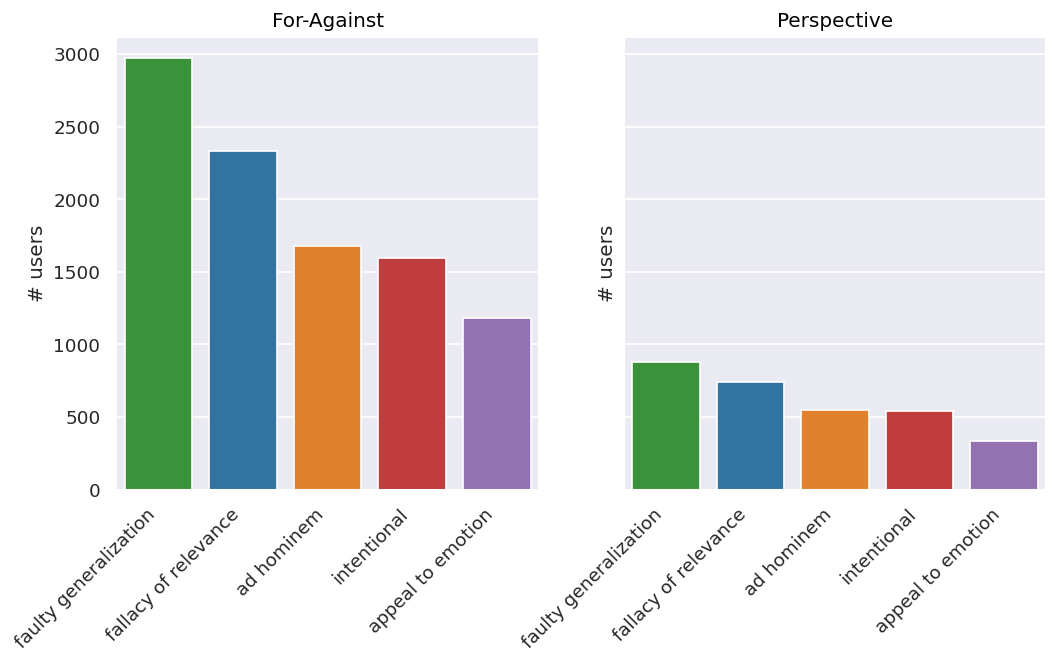

In [ ]:
plot_network_study('n_users', '# users')

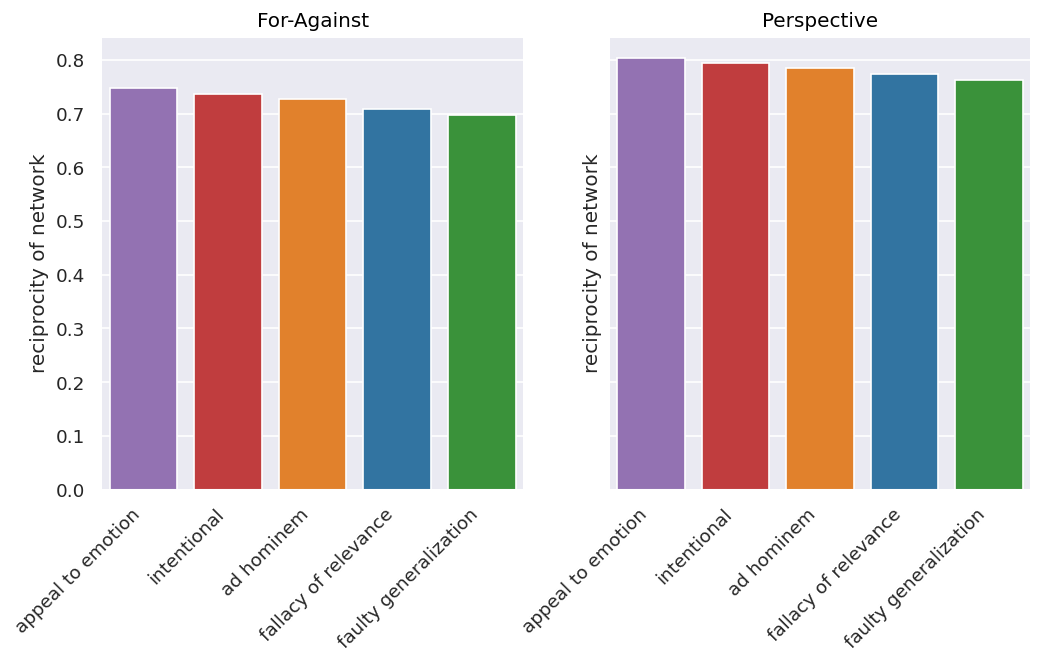

In [ ]:
plot_network_study('reciprocity', 'reciprocity of network')

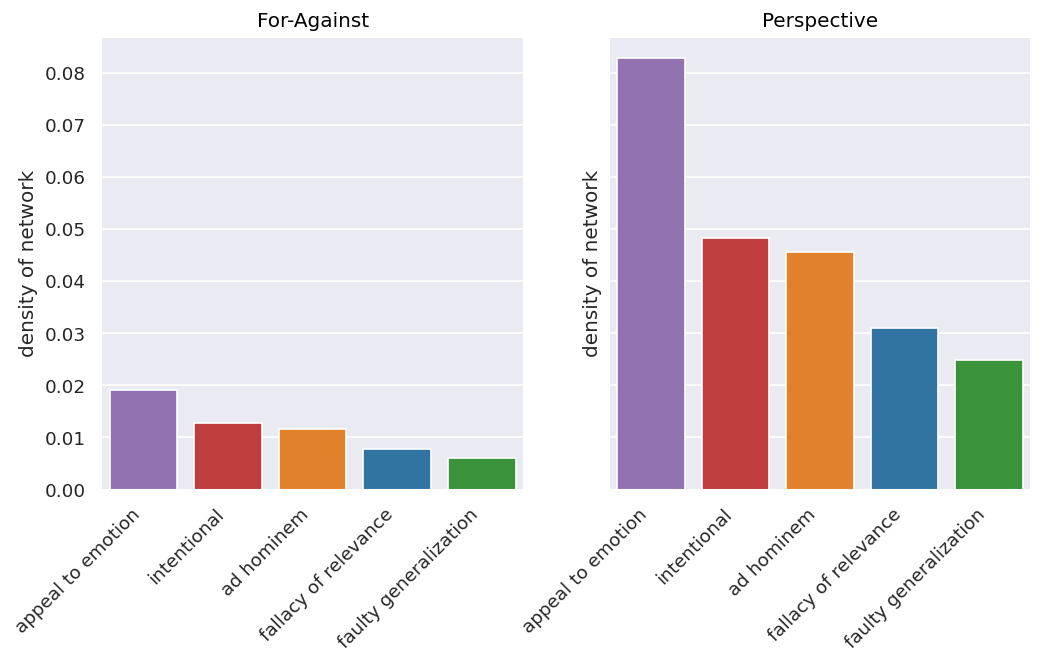

In [ ]:
plot_network_study('density', 'density of network')

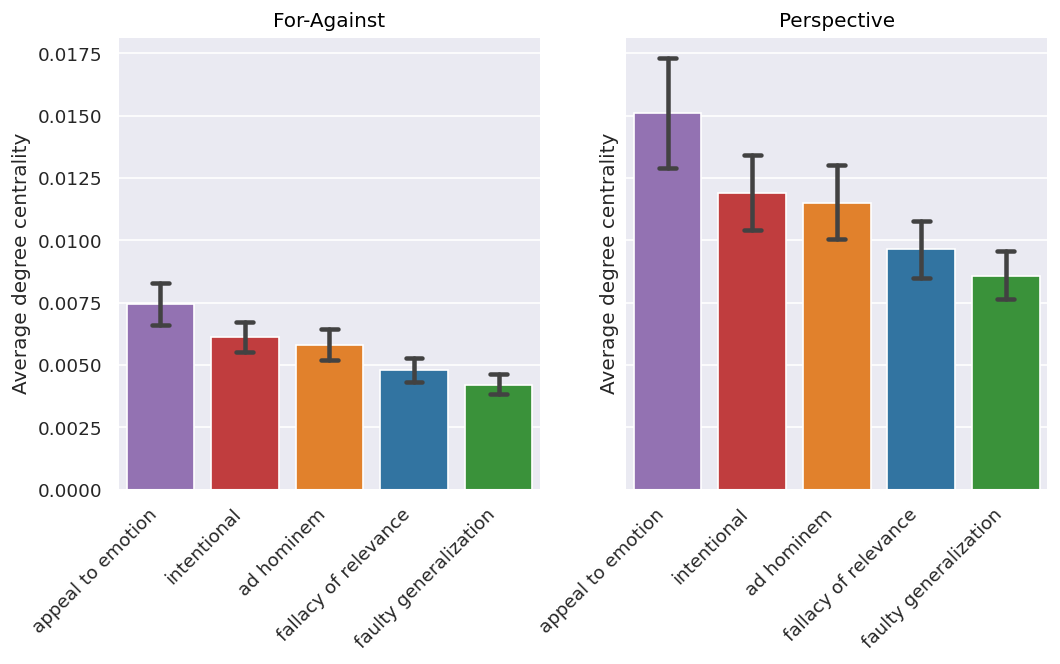

In [ ]:
plot_network_study('degree_centrality', 'Average degree centrality')

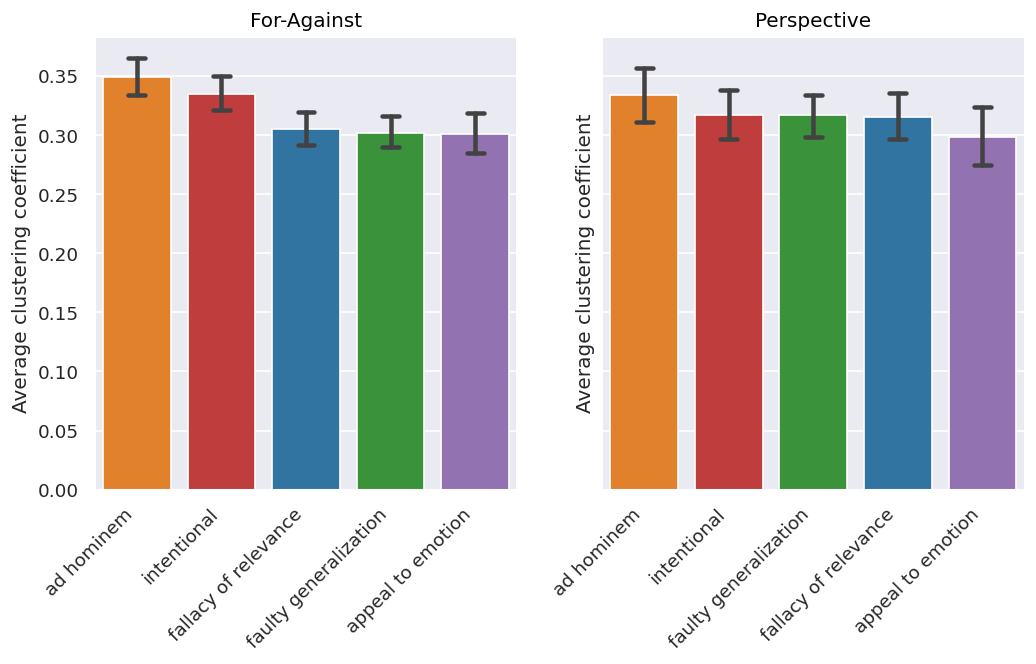

In [ ]:
plot_network_study('clustering_coeff', 'Average clustering coefficient')

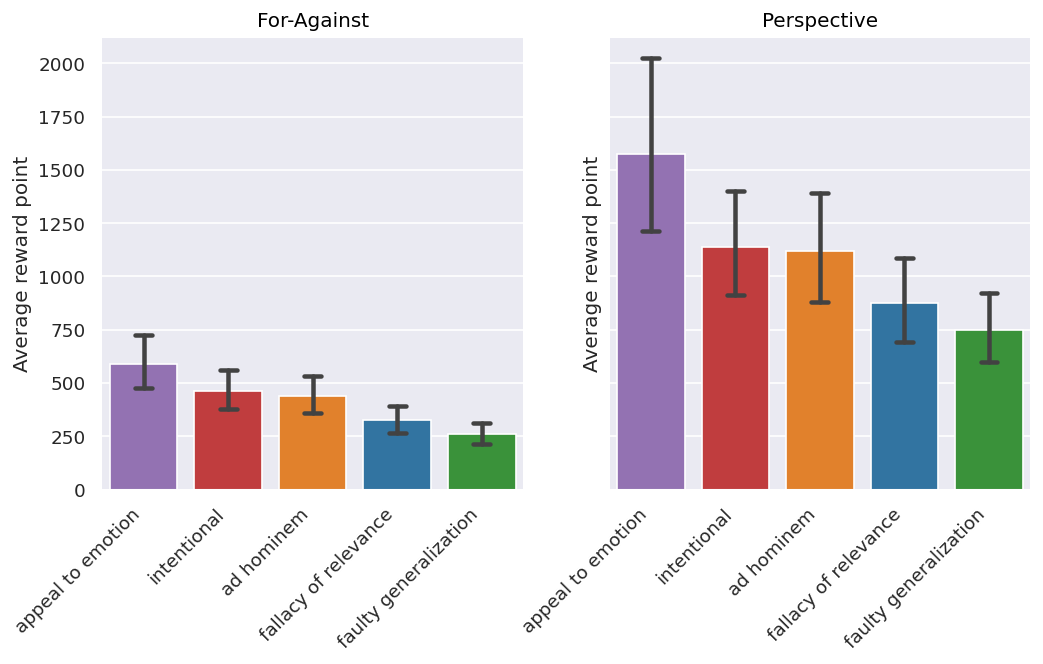

In [ ]:
plot_network_study('reward_points', 'Average reward point')

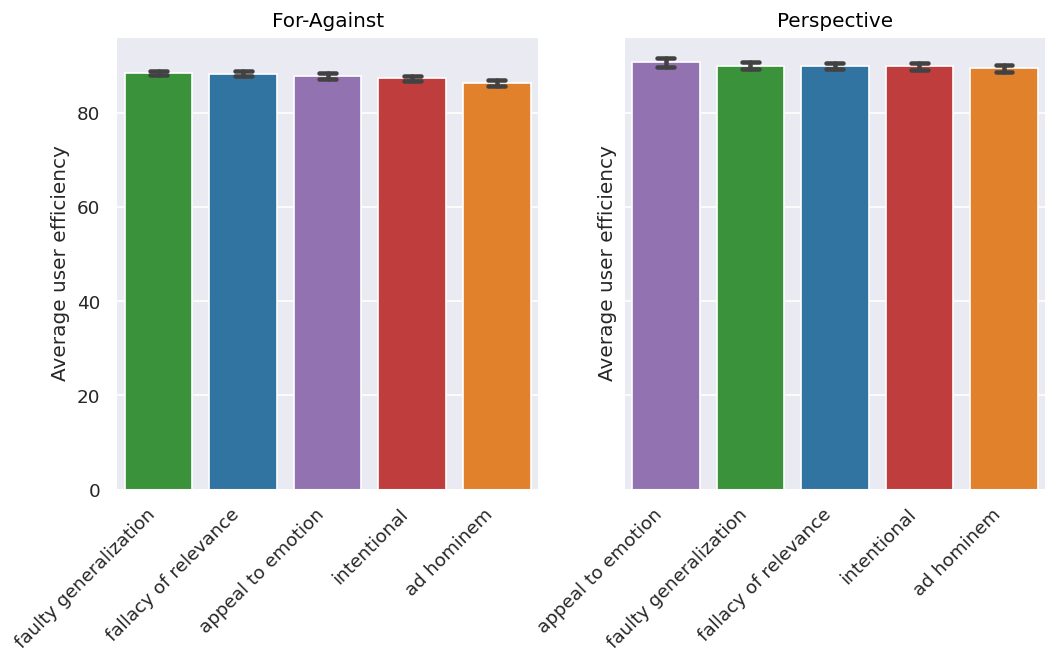

In [ ]:
plot_network_study('efficiency', 'Average user efficiency')

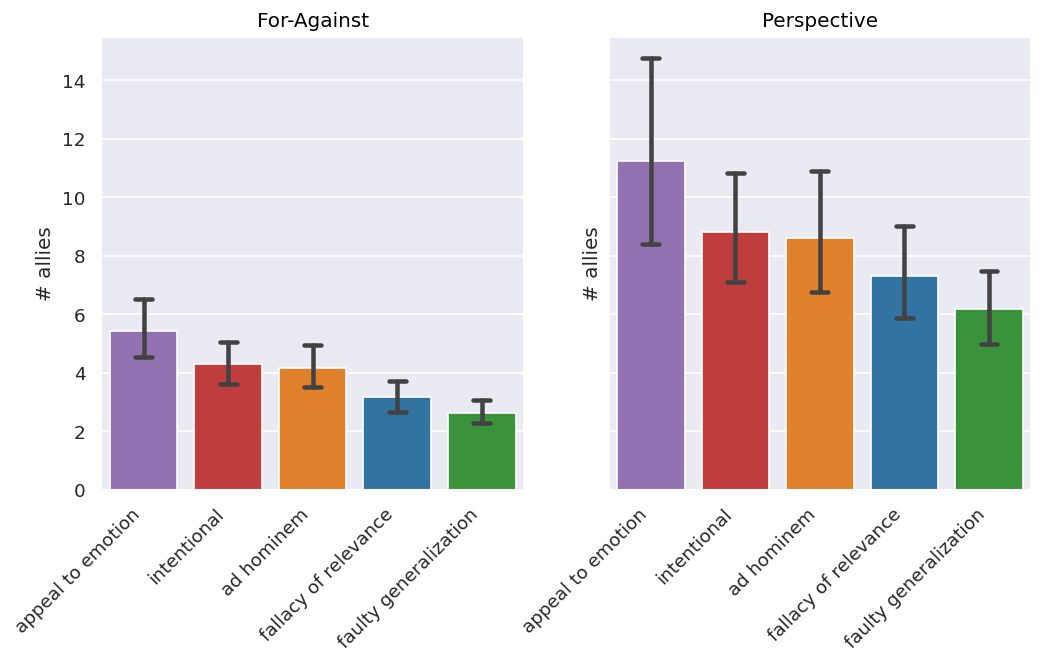

In [ ]:
plot_network_study('n_allies', '# allies')

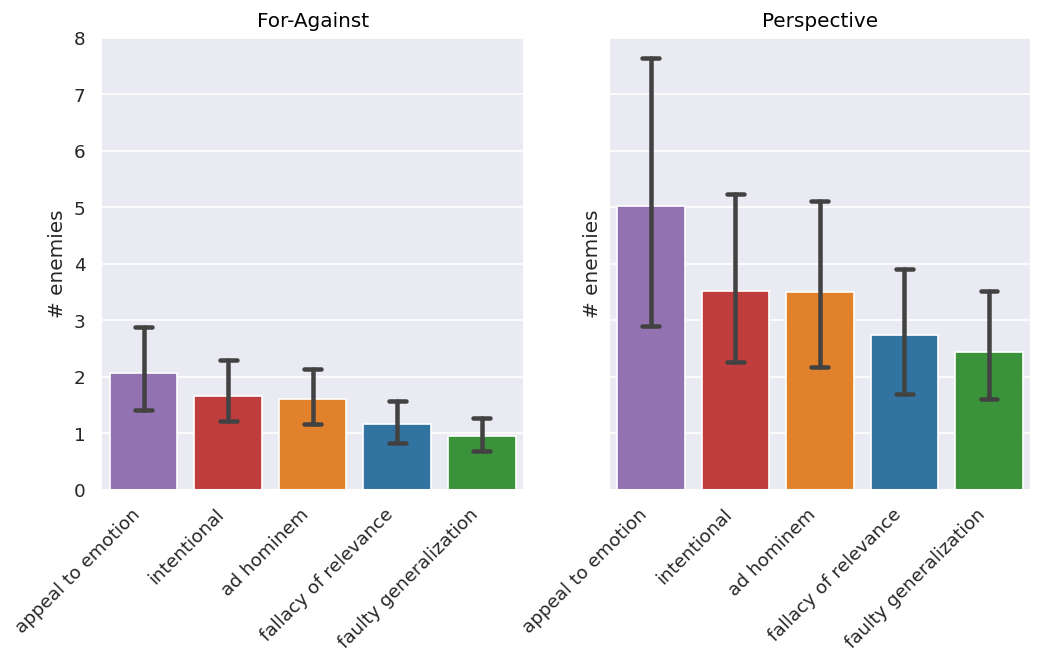

In [ ]:
plot_network_study('n_enemies', '# enemies')

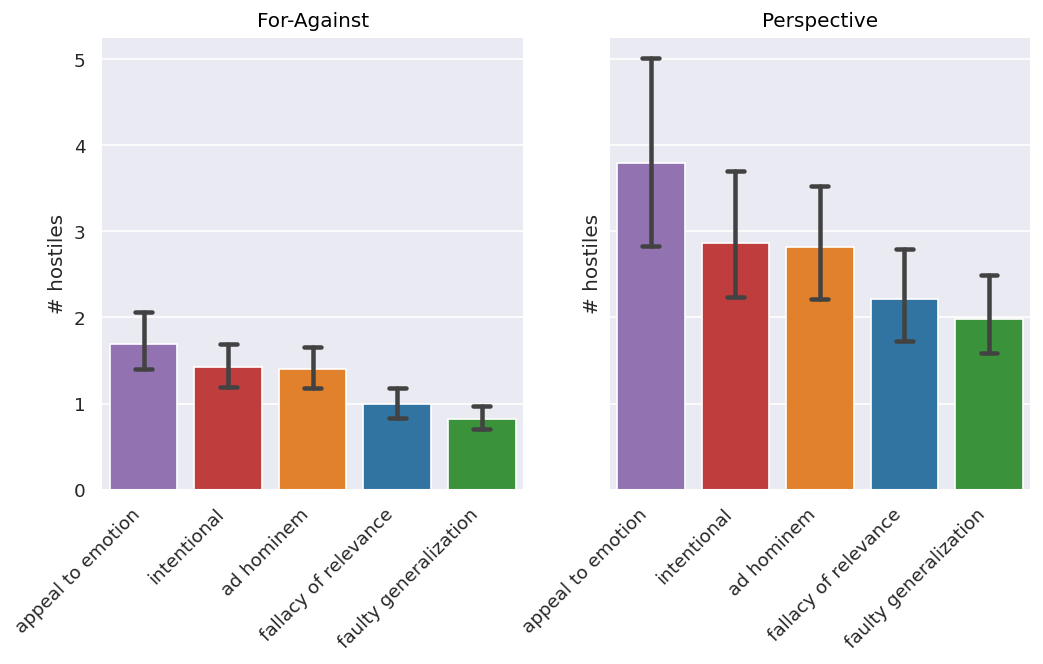

In [ ]:
plot_network_study('n_hostiles', '# hostiles')

## Linguistic study

In [ ]:
for_against_texts = dict()
perspective_texts = dict()

for k in classes_selected:
    for_against_texts[k] = [comment['body'].lower() for comment in for_against_logical[k]]
    perspective_texts[k] = [comment['body'].lower() for comment in perspective_logical[k]]

In [ ]:
for_against_trigger_count = dict()
perspective_trigger_count = dict()

for cls in classes_selected:
    print(cls)
    for_against_trigger_count[cls] = get_trigger_count(for_against_texts[cls], get_personal_pronoun_ids)
    perspective_trigger_count[cls] = get_trigger_count(perspective_texts[cls], get_personal_pronoun_ids)

fallacy of relevance


100%|██████████| 5099/5099 [01:26<00:00, 59.14it/s]


faulty generalization


100%|██████████| 5508/5508 [01:29<00:00, 61.51it/s] 


ad hominem


100%|██████████| 4974/4974 [01:15<00:00, 65.65it/s] 


intentional


100%|██████████| 4478/4478 [00:49<00:00, 90.65it/s] 


appeal to emotion


100%|██████████| 1335/1335 [00:17<00:00, 75.77it/s] 


In [ ]:
def plot_linguistic_study(property):

    def analyze_for_against(property, ax):
        data = list()
        for cls in classes_selected:
            data.append((cls, for_against_trigger_count[cls][property] / len(for_against_texts[cls])))

        data = sorted(data, reverse=True, key=lambda z: z[1])
        x, y = [], []

        for cls, val in data:
            x.append(cls)
            y.append(val)

        plt_data = dict()
        plt_data['x'] = x
        plt_data['y'] = y

        sns.barplot(data=plt_data, x='x', y='y', ax=ax, palette=palette)
        ax.set_title(f'For-Against: {property}', color='black')
        ax.set_ylabel('count')
        ax.set_xticklabels(x, rotation=45, ha='right')

    def analyze_perspective(property, ax):
        data = list()
        for cls in classes_selected:
            data.append((cls, perspective_trigger_count[cls][property] / len(perspective_texts[cls])))

        data = sorted(data, reverse=True, key=lambda z: z[1])
        x, y = [], []

        for cls, val in data:
            x.append(cls)
            y.append(val)

        plt_data = dict()
        plt_data['x'] = x
        plt_data['y'] = y

        sns.barplot(data=plt_data, x='x', y='y', ax=ax, palette=palette)
        ax.set_title(f'Perspective: {property}', color='black')
        ax.set_ylabel('count')
        ax.set_xticklabels(x, rotation=45, ha='right')

    fig, axes = plt.subplots(1, 2, sharey=True)
    analyze_for_against(property, axes[0])
    analyze_perspective(property, axes[1])

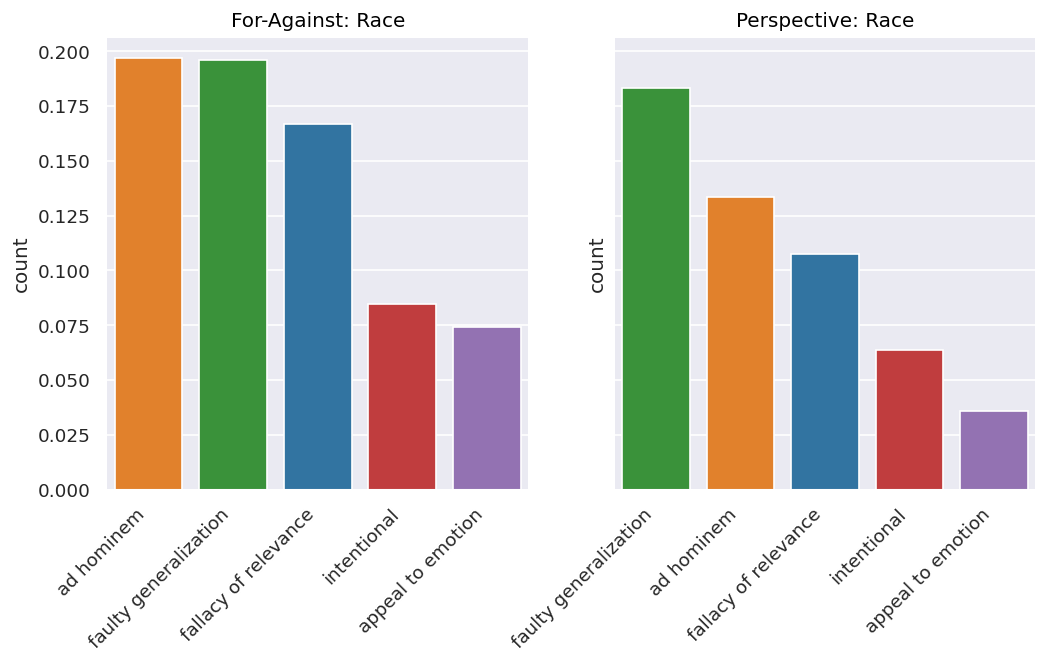

In [ ]:
plot_linguistic_study('Race')

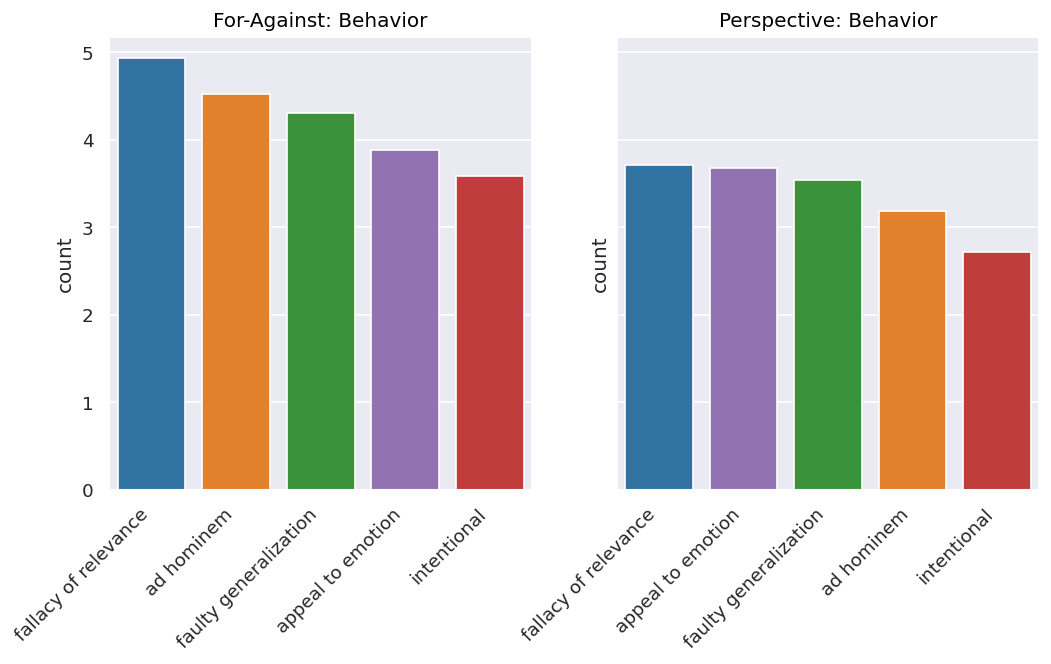

In [ ]:
plot_linguistic_study('Behavior')

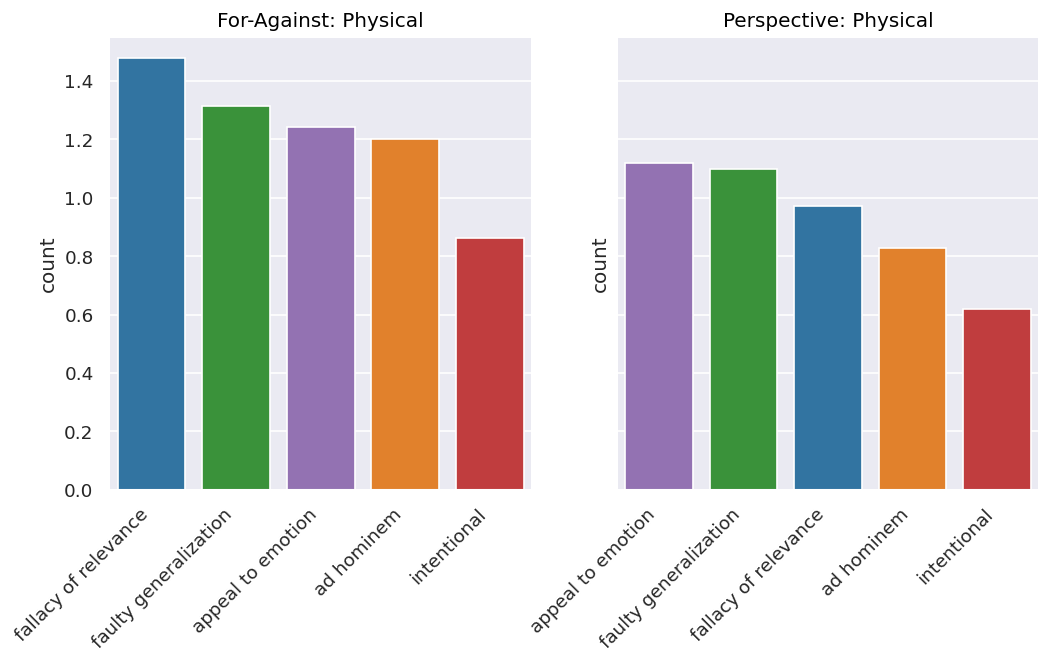

In [ ]:
plot_linguistic_study('Physical')

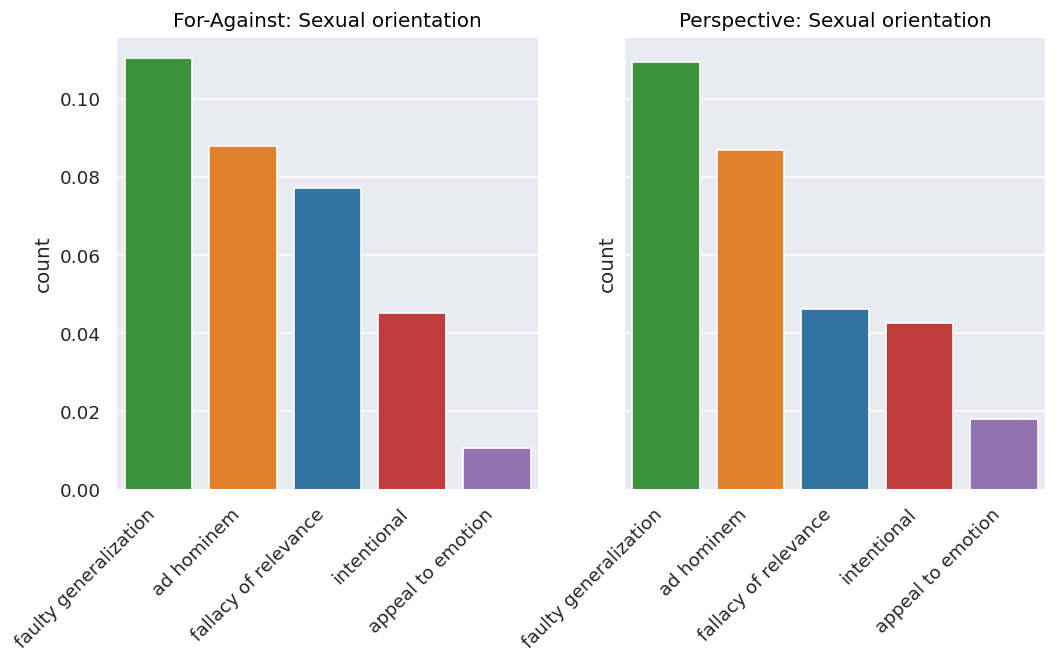

In [ ]:
plot_linguistic_study('Sexual orientation')

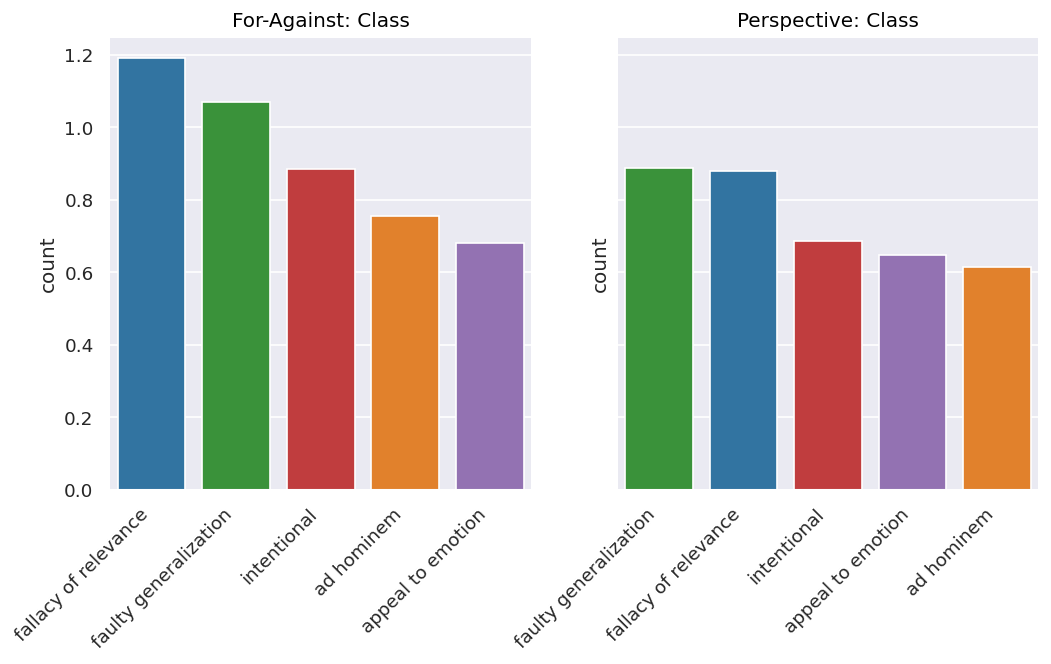

In [ ]:
plot_linguistic_study('Class')

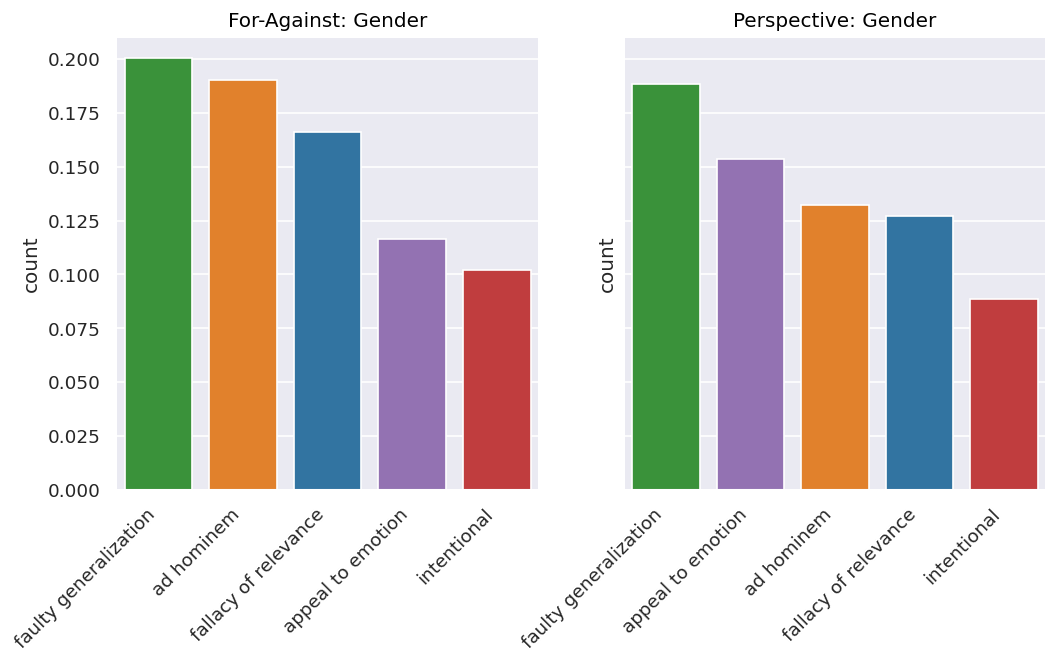

In [ ]:
plot_linguistic_study('Gender')

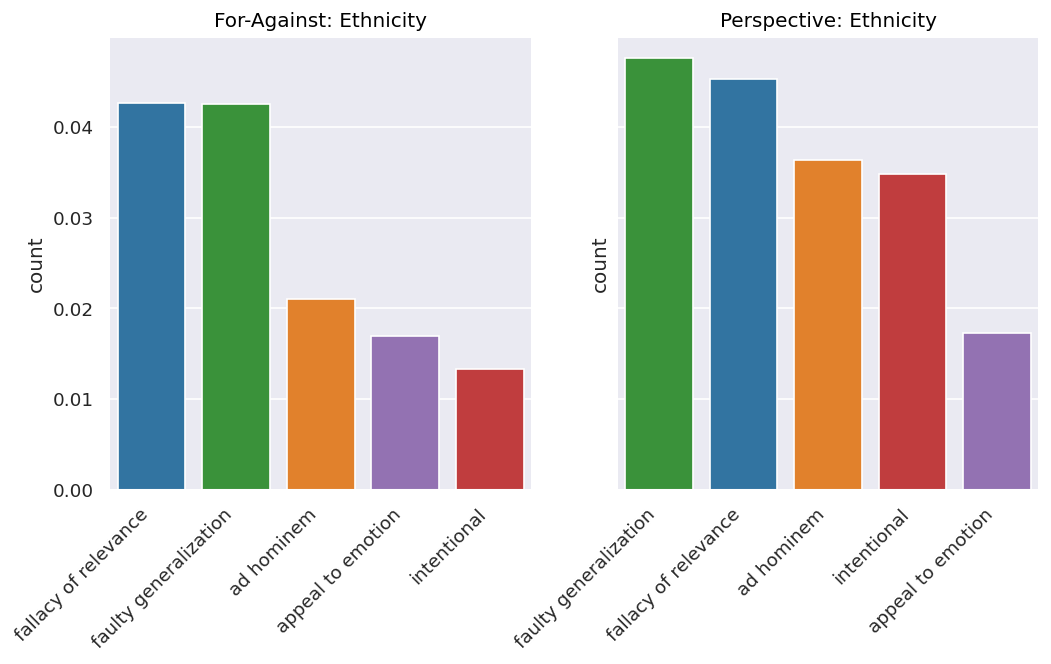

In [ ]:
plot_linguistic_study('Ethnicity')

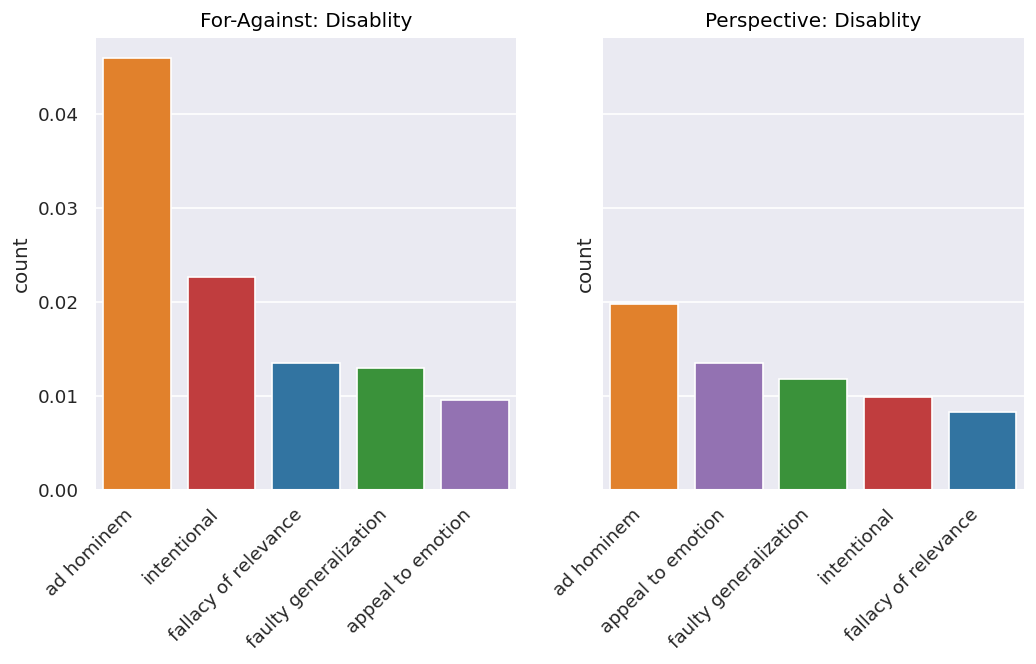

In [ ]:
plot_linguistic_study('Disablity')

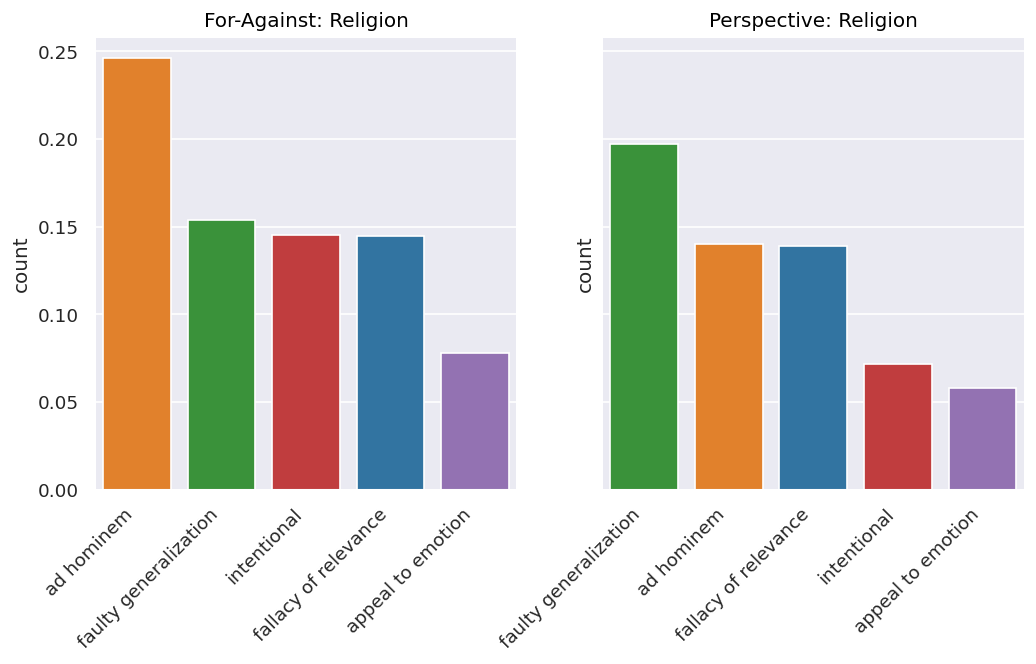

In [ ]:
plot_linguistic_study('Religion')

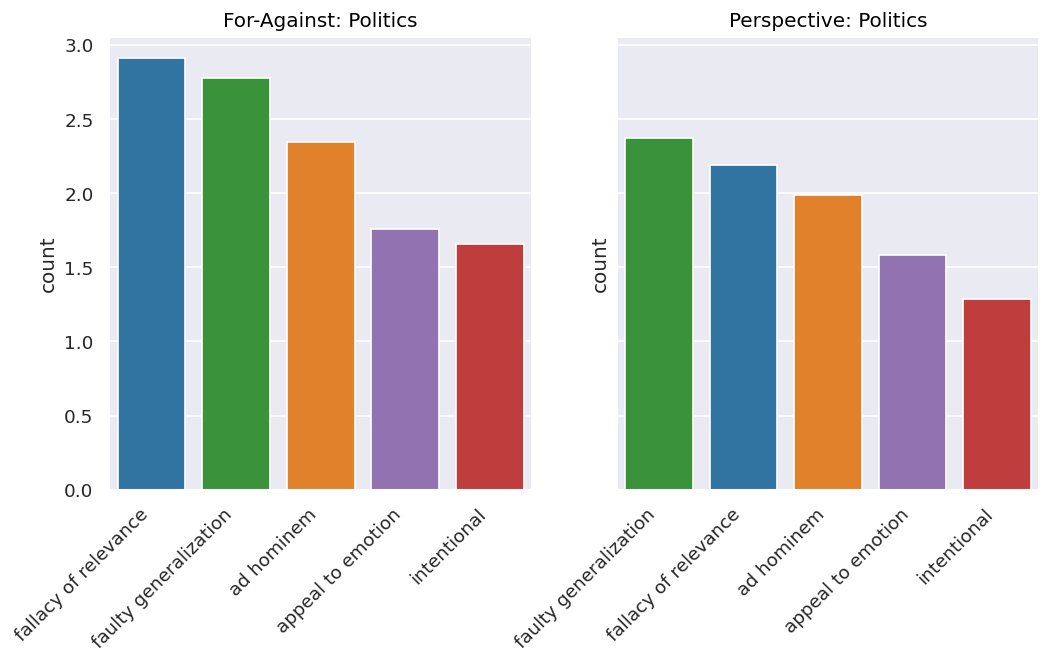

In [ ]:
plot_linguistic_study('Politics')

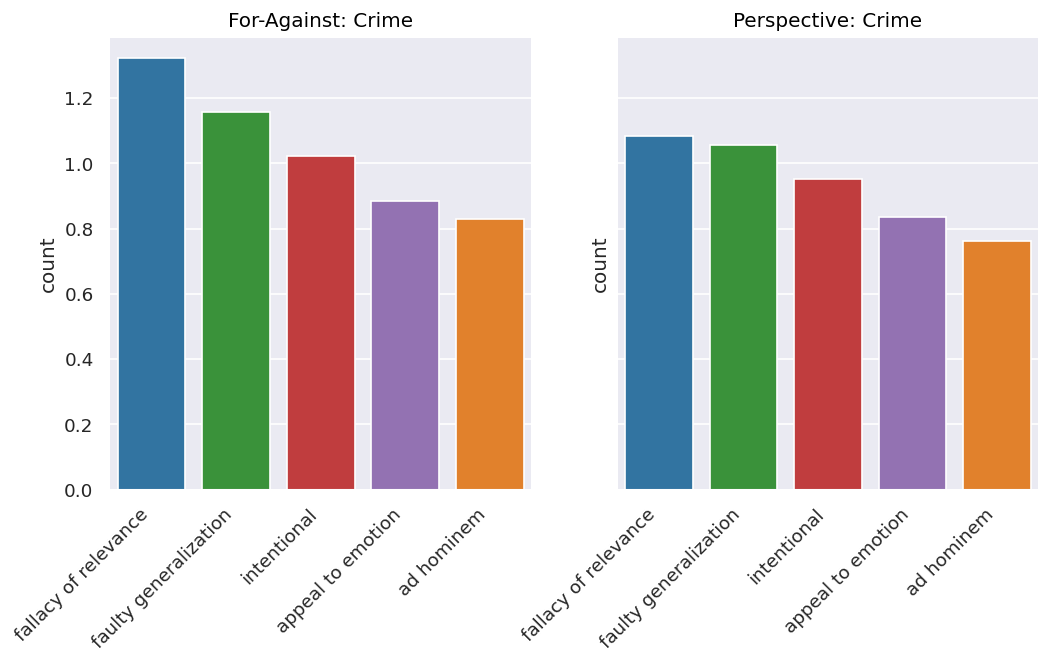

In [ ]:
plot_linguistic_study('Crime')

## Correlations

In [40]:
def save_obj(obj, file_path):
    with open(file_path, 'wb') as f:
        pickle.dump(obj, f)

def load_obj(obj, file_path):
    with open(file_path, 'rb') as f:
        return pickle.load(f)

In [38]:
for_against_texts_with_ctx = [(comment['body'].lower(), {'username': comment['author']}) for comment in for_against_debates['politics2']]
perspective_texts_with_ctx = [(comment['body'].lower(), {'username': comment['author']}) for comment in perspective_debates['politics2']]

In [39]:
for_against_trigger_count_with_ctx = get_trigger_count_by_username_ctx(for_against_texts_with_ctx, get_personal_pronoun_ids)
perspective_trigger_count_with_ctx = get_trigger_count_by_username_ctx(perspective_texts_with_ctx, get_personal_pronoun_ids)

100%|██████████| 31021/31021 [04:33<00:00, 113.27it/s]


In [41]:
save_obj(for_against_trigger_count_with_ctx, '/content/gdrive/MyDrive/Temp/67-for_against_trigger_count_with_ctx.pkl')
save_obj(perspective_trigger_count_with_ctx, '/content/gdrive/MyDrive/Temp/67-perspective_trigger_count_with_ctx.pkl')

In [58]:
# Helper functions for correlation study

def fn_clustering_coefficient(user):
    """Returns clustering coefficient for given user in the global network or ``None``
    if the user doesn't exists in the database
    :param user: username
    :type user: str
    """
    if user not in user_map:
        return 0
    if user_map[user] in clustering_dict:
        return clustering_dict[user_map[user]]
    return 0

def fn_degree_centrality(user):
    """Returns degree centrality for given user in the global network or ``0``
    if the user doesn't exists in the database
    :param user: username
    :type user: str
    """
    if user not in user_map:
        return 0
    if user_map[user] in centrality_dict:
        return centrality_dict[user_map[user]]
    return 0

def fn_reward_points(user):
    """Returns reward points for given user or ``0`` if the user doesn't exist
    in the database
    :param user: username
    :type user: str
    """
    if user in reward_points_map:
        return reward_points_map[user]
    return 0

def fn_efficiency(user):
    """Returns efficiency for given user or ``0`` if the user doesn't exist
    in the database
    :param user: username
    :type user: str
    """
    if user in efficiency_map:
        return efficiency_map[user]
    return 0

def fn_n_allies(user):
    """Returns #allies for given user or ``0`` if the user doesn't exist
    in the database
    :param user: username
    :type user: str
    """
    if user in allies_map:
        return allies_map[user]
    return 0

def fn_n_enemies(user):
    """Returns #enemies for given user or ``0`` if the user doesn't exist
    in the database
    :param user: username
    :type user: str
    """
    if user in enemies_map:
        return enemies_map[user]
    return 0

def fn_n_hostiles(user):
    """Returns #hostiles for given user or ``0`` if the user doesn't exist
    in the database
    :param user: username
    :type user: str
    """
    if user in hostiles_map:
        return hostiles_map[user]
    return 0

In [59]:
network_property_fns = [fn_clustering_coefficient, fn_degree_centrality, fn_reward_points,
                        fn_efficiency, fn_n_allies, fn_n_enemies, fn_n_hostiles]
network_property_labels = ['Clu. Coeff.', 'Deg. Centr.', 'Reward points', 'Eff.', '#allies', '#enemies', '#hostiles']

hate_labels = list(hate_targets.keys())

In [86]:
from scipy.stats import spearmanr

def plot_correlation_for_against():
    correlation_matrix = np.zeros((len(network_property_labels), len(hate_labels)))
    pvalue_matrix = np.zeros((len(network_property_labels), len(hate_labels)))

    for i, hate_type in enumerate(hate_labels):
        token_count_list = list()
        for user, token_count in for_against_trigger_count_with_ctx[hate_type].items():
            token_count_list.append(token_count)

        for j, ntwrk_prop in enumerate(network_property_labels):
            ntwrk_prop_list = list()
            for user in for_against_trigger_count_with_ctx[hate_type].keys():
                ntwrk_prop_list.append(network_property_fns[j](user))
            
            corr, pval = spearmanr(token_count_list, ntwrk_prop_list)
            correlation_matrix[j, i] = corr
            pvalue_matrix[j, i] = pval
    
    fig, axes = plt.subplots(1, 2)
    sns.heatmap(correlation_matrix, ax=axes[0], cmap='crest', linewidth=.5)
    axes[0].set_title('Spearman correlation')
    axes[0].set_yticklabels(network_property_labels, rotation=0, ha='right')
    axes[0].set_xticklabels(hate_labels, rotation=90, ha='right')
    sns.heatmap(pvalue_matrix, ax=axes[1], cmap='crest', linewidth=.5)
    axes[1].set_title('P-value')
    axes[1].set_yticklabels(network_property_labels, rotation=0, ha='right')
    axes[1].set_xticklabels(hate_labels, rotation=90, ha='right')

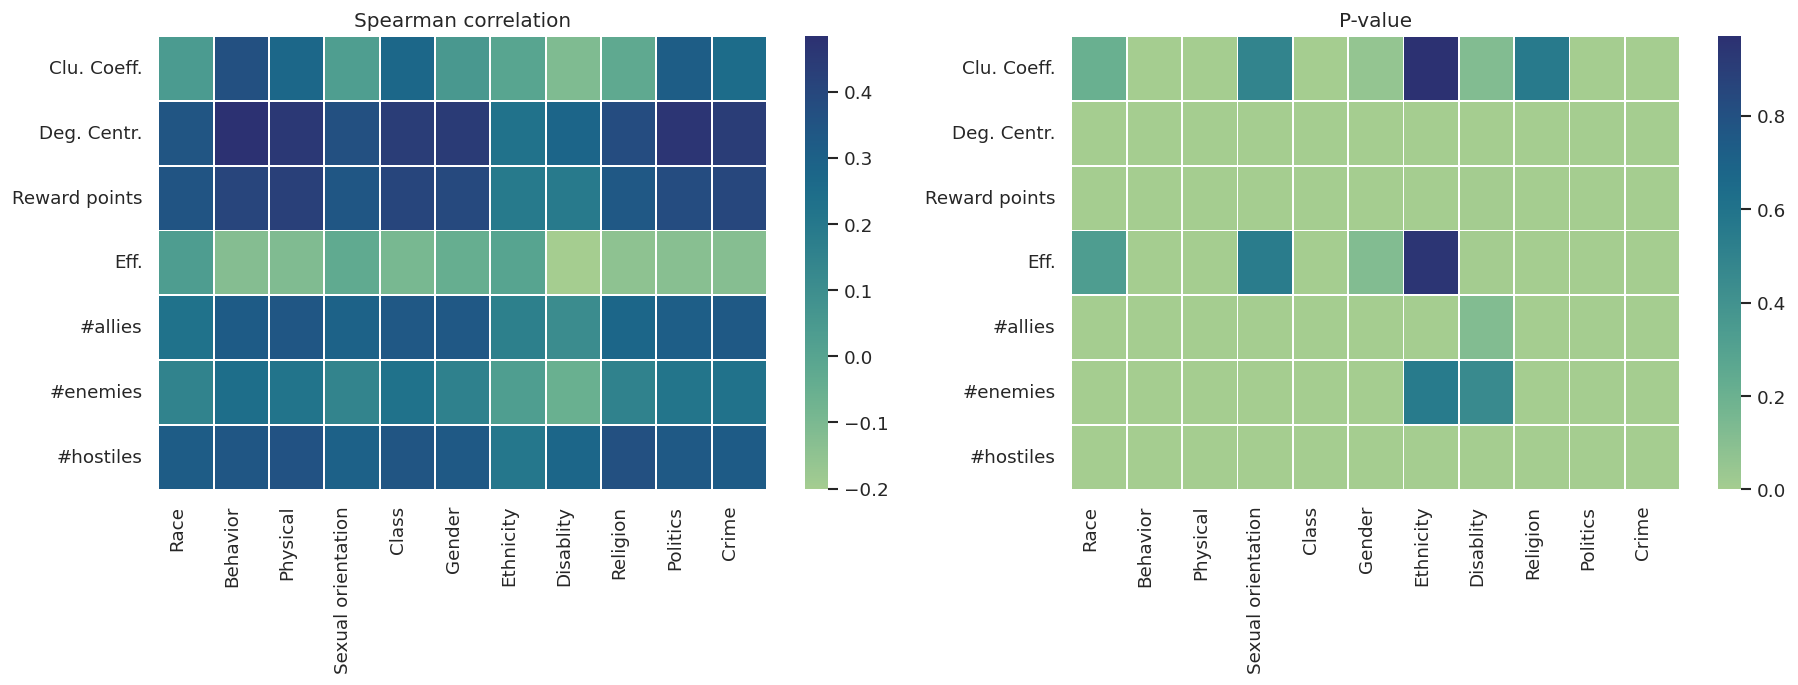

In [87]:
plot_correlation_for_against()

In [88]:
def plot_correlation_perspective():
    correlation_matrix = np.zeros((len(network_property_labels), len(hate_labels)))
    pvalue_matrix = np.zeros((len(network_property_labels), len(hate_labels)))

    for i, hate_type in enumerate(hate_labels):
        token_count_list = list()
        for user, token_count in perspective_trigger_count_with_ctx[hate_type].items():
            token_count_list.append(token_count)

        for j, ntwrk_prop in enumerate(network_property_labels):
            ntwrk_prop_list = list()
            for user in perspective_trigger_count_with_ctx[hate_type].keys():
                ntwrk_prop_list.append(network_property_fns[j](user))
            
            corr, pval = spearmanr(token_count_list, ntwrk_prop_list)
            correlation_matrix[j, i] = corr
            pvalue_matrix[j, i] = pval
    
    fig, axes = plt.subplots(1, 2)
    sns.heatmap(correlation_matrix, ax=axes[0], cmap='crest', linewidth=.5)
    axes[0].set_title('Spearman correlation')
    axes[0].set_yticklabels(network_property_labels, rotation=0, ha='right')
    axes[0].set_xticklabels(hate_labels, rotation=90, ha='right')
    sns.heatmap(pvalue_matrix, ax=axes[1], cmap='crest', linewidth=.5)
    axes[1].set_title('P-value')
    axes[1].set_yticklabels(network_property_labels, rotation=0, ha='right')
    axes[1].set_xticklabels(hate_labels, rotation=90, ha='right')

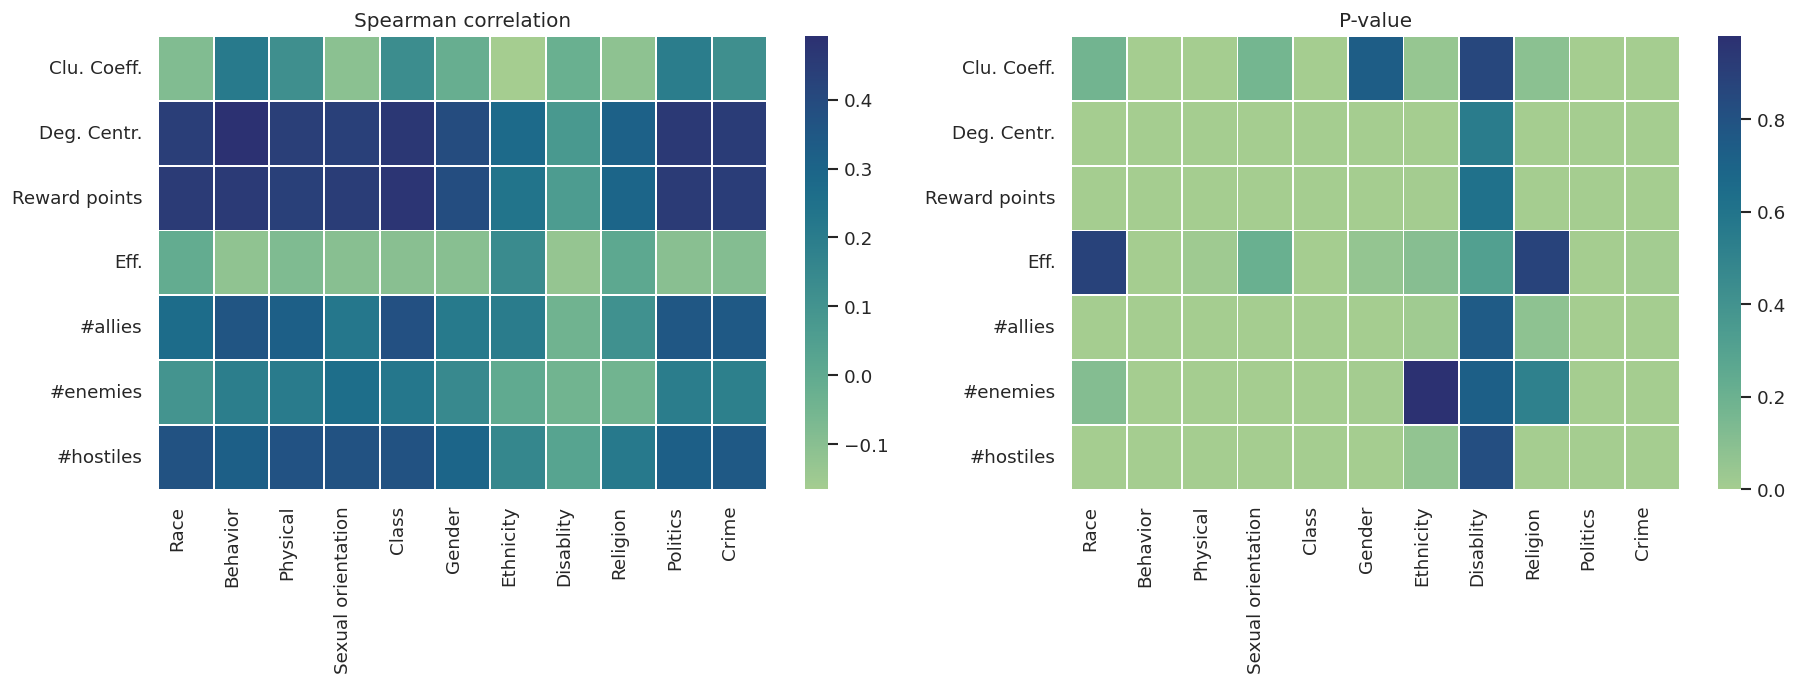

In [89]:
plot_correlation_perspective()